### import python library

In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.neighbors
from sklearn.metrics.cluster import adjusted_rand_score
import sklearn
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
import phenograph
import numpy as np
import random
from copy import deepcopy
import pickle
import os
import argparse
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### set up Python and R Path

In [2]:
os.environ['R_HOME'] = '/opt/R/4.0.2/lib/R'
os.environ['R_USER'] = '~/anaconda3/lib/python3.8/site-packages/rpy2'
os.environ['LD_LIBRARY_PATH'] = '/opt/R/4.0.2/lib/R/lib'
os.environ['PYTHONHASHSEED'] = '1234'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

### generate simulation dataset

#### initailize the domain clusters
1. seed: fix random seed
2. Spatial_cluster: number of domains. Each domain we will assign a dominated cell type
3. Spatial_samples: number of dominated cell

In [3]:
seed=123
spatial_clusters=(0,4)
spatial_samples=1000
np.random.seed(seed)
data = {}
cluster_ids = np.random.randint(spatial_clusters[0], spatial_clusters[1], size=spatial_samples)
data['cell_cluster'] = cluster_ids

#### Assign the cluster ids to the spatial domain. Each cell had its corresponding coordinates
1. gene_feat: the dimension for final gene input
2. img_feat: the dimension for image input
3. gene_latent: the latent dimension for gene expression
4. img_latent: the latent dimension for img

In [4]:
gene_feat=500
img_feat=500
gene_latent=30
img_latent=30

coordinate = np.zeros((cluster_ids.shape[0], 2))
gene_data = np.zeros((cluster_ids.shape[0], gene_feat))
img_data = np.zeros((cluster_ids.shape[0], img_feat))
Z_a = np.zeros([gene_latent, spatial_samples])
Z_b = np.zeros([img_latent, spatial_samples])


In the simulation data, we assume a cell type will dominate a domain layer.
Here we generate the coordinate of the cells/spots to an individual coordinates.

In [5]:
spa_regions = [
        ((10, 240),(10, 240)),
        ((10, 240),(260, 490)),
        ((260,490),(10, 240)),
        ((260,490),(260,490))
]

Z_a = np.zeros([gene_latent, spatial_samples])
Z_b = np.zeros([img_latent, spatial_samples])
mus = []
for spa_clus in list(set(cluster_ids)):
    idx = (cluster_ids == spa_clus)
    range_x, range_y = spa_regions[spa_clus - spatial_clusters[0]]
    sx = np.random.uniform(range_x[0], range_x[1], size=idx.sum())
    sy = np.random.uniform(range_y[0], range_y[1], size=idx.sum())
    coordinate[idx, 0] = sx
    coordinate[idx, 1] = sy        

    cluster_mu1 = np.random.random([gene_latent]) - 0.5
    cluster_mu2 = cluster_mu1
    mus.append((cluster_mu1, cluster_mu2))
    Z_a[:, idx] = np.random.multivariate_normal(mean=cluster_mu1, cov=0.1*np.eye(gene_latent), size=idx.sum()).transpose()
    Z_b[:, idx] = np.random.multivariate_normal(mean=cluster_mu2, cov=0.1*np.eye(img_latent), size=idx.sum()).transpose()
    
data['sx'] = coordinate[:, 0]
data['sy'] = coordinate[:, 1]


Base on the latent dimensions, we add noise and matrix transformation to generate the image inputs and the gene inputs.

In [6]:
from simulation_utils import gen_feats

In [7]:
sigma_gene = 0.5
sigma_img = 0.5
dropout_gene = 0.2
dropout_img = 0.2

X_a, Y_a = gen_feats(spatial_samples, Z_a, gene_feat, gene_latent, sigma_gene, dropout_gene)
data['gene_data_full'] = X_a
data['gene_data_dropout'] = Y_a
    
X_b, Y_b = gen_feats(spatial_samples, Z_b, img_feat, img_latent, sigma_img, dropout_img)
data['img_data_full'] = X_b
data['img_data_dropout'] = Y_b

### generate the mixsure cells into the spatial profiling.

1. ratio: the ratio of noise cell types in each domain
2. mix_regions: the coordinate range for noise cell types.
3. add_noise_area: the index of mix_region in the spa_regions
4. prior: we assume the mixed cells shared the similar distribution to the dominated cells. For a domain recognition method, the method should detect the four domain layers while each domain may share multiple cells.
4. mu_prior: the mu for each mixing cells

In [8]:
ratio=0.3
mix_regions = [
        ((10, 240), (10, 240)),
        ((10, 240), (10, 240)),
        ((260, 490), (10, 240)),
        ((260, 490), (10, 240)),
        ((10, 240), (260, 490))
]
add_noise_area = [0,0,2,2,1]
prior = [[0, 0.1], [0.1, 0.5], [0, 0.1], [0.1, 0.5], [0.1, 0.1]]

mu_prior = [
    (mus[add_noise_area[i]][0] + prior[i][0], mus[add_noise_area[i]][1] + prior[i][1]) for i in range(len(prior))
]

generate the cluster_id for mixed datasets 
the initialization of mixing cells were same as the dominiate cells, with different nums of samples

In [9]:
mix_cluster = (4,9)
mix_samples = int(ratio * spatial_samples)

np.random.seed(seed)
mix_data = {}

mix_cluster_ids = np.random.randint(mix_cluster[0], mix_cluster[1], size=mix_samples)
mix_data['cell_cluster'] = mix_cluster_ids

simulate the mixing gene expression and the img features.

In [10]:
coordinate = np.zeros((mix_cluster_ids.shape[0], 2))
gene_data = np.zeros((mix_cluster_ids.shape[0], gene_feat))
img_data = np.zeros((mix_cluster_ids.shape[0], img_feat))
    
Z_a = np.zeros([gene_latent, mix_samples])
Z_b = np.zeros([img_latent, mix_samples])
for spa_clus in list(set(mix_cluster_ids)):
    idx = (mix_cluster_ids == spa_clus)
    range_x, range_y = mix_regions[spa_clus - mix_cluster[0]]
    sx = np.random.uniform(range_x[0], range_x[1], size=idx.sum())
    sy = np.random.uniform(range_y[0], range_y[1], size=idx.sum())
    coordinate[idx, 0] = sx
    coordinate[idx, 1] = sy        

    cluster_mu1, cluster_mu2 = mu_prior[spa_clus - mix_cluster[0]]
    Z_a[:, idx] = np.random.multivariate_normal(mean=cluster_mu1, cov=0.1*np.eye(gene_latent), size=idx.sum()).transpose()
    Z_b[:, idx] = np.random.multivariate_normal(mean=cluster_mu2, cov=0.1*np.eye(img_latent), size=idx.sum()).transpose()
    
mix_data['sx'] = coordinate[:, 0]
mix_data['sy'] = coordinate[:, 1]

generate the inputs of mixing data

In [11]:
mix_sigma_gene=0.5
mix_sigma_img=0.5
mix_dropout_gene=0.3
mix_dropout_img=0.3

X_a, Y_a = gen_feats(mix_samples, Z_a, gene_feat, gene_latent, mix_sigma_gene, mix_dropout_gene)
mix_data['gene_data_full'] = X_a
mix_data['gene_data_dropout'] = Y_a
    
X_b, Y_b = gen_feats(mix_samples, Z_b, img_feat, img_latent, mix_sigma_img, mix_dropout_img)
mix_data['img_data_full'] = X_b
mix_data['img_data_dropout'] = Y_b

Combine the dominating cells and the mixing cells

In [12]:
from simulation_utils import combine

In [13]:
combine_data = combine(data, mix_data, spa_regions)

Visualize the combine data

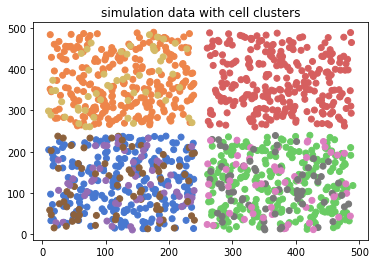

In [14]:
colors = []
my_cmap = sns.color_palette('muted', as_cmap=True)
for cid in combine_data['cell_cluster']:
    colors.append(my_cmap[cid])
plt.title("simulation data with cell clusters")
plt.scatter(combine_data['sx'], combine_data['sy'], c=colors)

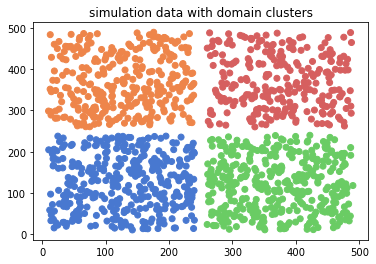

In [15]:
colors = []
my_cmap = sns.color_palette('muted', as_cmap=True)
for cid in combine_data['domain_cluster']:
    colors.append(my_cmap[cid])
plt.title("simulation data with domain clusters")
plt.scatter(combine_data['sx'], combine_data['sy'], c=colors)

save the generated simulation data

In [16]:
from simulation_utils import save_data_pickle 
if not os.path.exists('simulation'):
    os.mkdir('simulation')
if not os.path.exists('simulation_results'):
    os.mkdir('simulation_results')       
        
save_name = 'simulation/jupyter_demo.pkl'
save_data_pickle(combine_data, save_name)

run sigra and save the embedings and predictions

In [17]:
from simulation_utils import run_sigra_model

jupyter_demo
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.3775362968444824 seconds
Jaccard graph constructed in 1.188178539276123 seconds
Wrote graph to binary file in 0.059494733810424805 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.255959
After 4 runs, maximum modularity is Q = 0.260094
After 11 runs, maximum modularity is Q = 0.26197
Louvain completed 31 runs in 1.8679187297821045 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.8707802295684814 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.44530296325683594 seconds
Jaccard graph constructed in 0.8583972454071045 seconds
Wrote graph to binary file in 0.047475337982177734 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.297947
Louvain completed 21 runs in 1.164954423904419 seconds
Sorting communities by size, p

100%|███████████████████████████████████████████████| 800/800 [01:03<00:00, 12.64it/s]


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6467523574829102 seconds
Jaccard graph constructed in 1.637369155883789 seconds
Wrote graph to binary file in 0.07500696182250977 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.647295
Louvain completed 21 runs in 2.993610382080078 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.231403112411499 seconds
jupyter_demo 0.7481


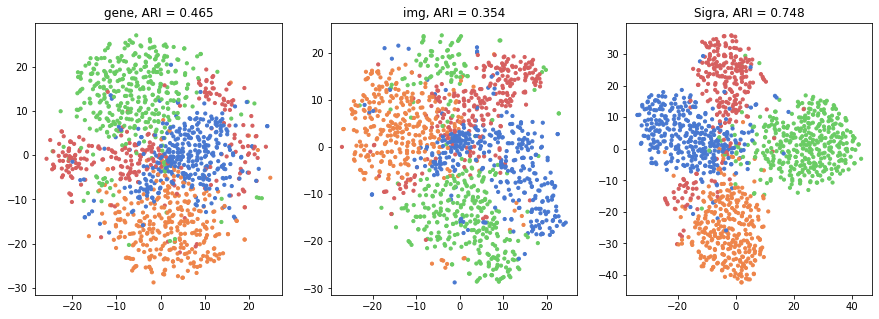

In [18]:
sigra_pred, sigra_emb = run_sigra_model('simulation/', 'jupyter_demo', n_epochs=800, hidden_dims=[512, 30], seed=seed, lambda_1=0.5, lambda_2=0.5, lambda_3=1.0, graph_type='spatial', gt_type='domain', vis=1)

calculating the ari

In [19]:
from simulation_utils import save_method_pred
emb_df = pd.DataFrame(sigra_emb)
emb_df.to_csv('simulation_results/sigra_emb_spatial_jupyter_demo.csv')
save_method_pred('simulation_results/jupyter_demo.csv', sigra_pred, 'sigra')

In [20]:
csv = pd.read_csv('simulation_results/jupyter_demo.csv', header=0, index_col=0)
print(csv)

      label_domain  label_cell  gene_pca  img_pca  sigra
0                2           2         0        6      0
1                1           1         1        1      1
2                2           2         0        1      0
3                2           2         0        0      0
4                0           0         2        7      4
...            ...         ...       ...      ...    ...
1295             0           4         2        5      3
1296             0           5         6        3      3
1297             1           8         1        1      1
1298             2           7         0        3      0
1299             2           6         0        0      0

[1300 rows x 5 columns]


In [21]:
ari = adjusted_rand_score(csv['label_domain'], csv['sigra'])
print("ari: %.2f"%(ari))

ari: 0.75
